# Simultaneously fit multiple lightcurves with airmass detrending

Here we will fit multiple lightcurves simultaneously using the global fitter in exotic. We will set up bounds for each lightcurve that specify what parameters to fit along with 'global' bounds that are shared between all lightcurves. 

![](https://s3.amazonaws.com/aasie/images/0004-6256/164/5/null/ajac8deef3_hr.jpg)

This notebook will show you how to reproduce something similar to Figure 4 in a study on HD 80606 b, https://ui.adsabs.harvard.edu/abs/2022AJ....164..178P/abstract 

Please cite that paper if you use this code

## Find lightcurve data in the Exoplanet Watch Database

The command `get` will fetch priors, light curves and an ephemeris (O-C) for each target.

In [1]:
import os
import numpy as np
from copy import deepcopy
from exotic.api.ew import ExoplanetWatch, translate_keys
from IPython.display import display, Image
import matplotlib.pyplot as plt
%matplotlib inline


# This will load the results JSON from the link above
EW = ExoplanetWatch()
print(EW.target_list)

# names are case and space sensitive
target ='WASP-77 A b'
result = EW.get(target)

# directory to save outputs to
output_dir = target.replace(" ","_").replace("-","_")

# make the directory if it doesn't exist
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

# list the result properties
result.__dict__.keys()

Loaded 358 targets
['CoRoT-11 b', 'CoRoT-14 b', 'CoRoT-18 b', 'CoRoT-1 b', 'CoRoT-27 b', 'CoRoT-29 b', 'CoRoT-2 b', 'CoRoT-5 b', 'CoRoT-7 b', 'CoRoT-8 b', 'CoRoTID 223977153 b', 'EPIC 206042996 c', 'Gaia-1 b', 'Gaia-2 b', 'GJ 1214 b', 'GJ 3470 b', 'GJ 436 b', 'GPX-1 b', 'HAT-P-11 b', 'HAT-P-12 b', 'HAT-P-13 b', 'HAT-P-16 b', 'HAT-P-17 b', 'HAT-P-18 b', 'HAT-P-19 b', 'HAT-P-1 b', 'HAT-P-20 b', 'HAT-P-21 b', 'HAT-P-22 b', 'HAT-P-23 b', 'HAT-P-25 b', 'HAT-P-26 b', 'HAT-P-27 b', 'HAT-P-28 b', 'HAT-P-29 b', 'HAT-P-30 b', 'HAT-P-32 b', 'HAT-P-33 b', 'HAT-P-34 b', 'HAT-P-36 b', 'HAT-P-37 b', 'HAT-P-38 b', 'HAT-P-39 b', 'HAT-P-3 b', 'HAT-P-41 b', 'HAT-P-44 b', 'HAT-P-45 b', 'HAT-P-49 b', 'HAT-P-4 b', 'HAT-P-50 b', 'HAT-P-51 b', 'HAT-P-52 b', 'HAT-P-53 b', 'HAT-P-54 b', 'HAT-P-55 b', 'HAT-P-56 b', 'HAT-P-57 b', 'HAT-P-59 b', 'HAT-P-5 b', 'HAT-P-65 b', 'HAT-P-68 b', 'HAT-P-6 b', 'HAT-P-70 b', 'HAT-P-7 b', 'HAT-P-8 b', 'HAT-P-9 b', 'HATS-18 b', 'HATS-22 b', 'HATS-24 b', 'HATS-2 b', 'HATS-33 b', '

dict_keys(['raw_result', 'host', 'name', 'priors', 'timestamp', 'identifier', 'reduction_count', 'observation_count', 'ephemeris', 'observations'])

## Priors
A list of stellar and planetary parameters with references. These are used to calculate a light curve model with non-linear limb darkening.

In [2]:
result.priors

{'R*': {'units': 'Sol',
  'value': '0.95',
  'reference': 'Kokori%20et%20al.%202022',
  'uncertainty': '0.01'},
 'RA': {'units': 'decimal',
  'value': '37.1555223',
  'reference': None,
  'uncertainty': None},
 'Rp': {'units': 'R_Earth',
  'value': '13.79',
  'reference': 'Cort&eacute;s-Zuleta%20et%20al.%202020',
  'uncertainty': '0.35'},
 'T*': {'units': 'K',
  'value': '5500.0',
  'reference': 'Kokori%20et%20al.%202022',
  'uncertainty': '80.0'},
 'Tc': {'units': 'BJD-TDB',
  'value': '2457658.8889',
  'reference': 'Ivshina%20&amp;%20Winn%202022',
  'uncertainty': '0.00014'},
 'DEC': {'units': 'decimal',
  'value': '-7.0606675',
  'reference': None,
  'uncertainty': None},
 'Tcs': [{'units': 'BJD, BJD-TDB',
   'value': '2455870.4500266667',
   'reference': 'Bonomo%20et%20al.%202017,%20Turner%20et%20al.%202016,%20Maxted%20et%20al.%202013',
   'uncertainty': '0.00014'},
  {'units': 'BJD-TDB',
   'value': '2456663.34757',
   'reference': 'Kokori%20et%20al.%202022',
   'uncertainty': '0.

In [3]:
# translate json to exotic compatible format
transit_priors = {
    'ecc': float(result.priors['ecc']['value']),
    'inc': float(result.priors['inc']['value']),
    'omega': float(result.priors['omega']['value']),
    'tmid': float(result.priors['Tc']['value']),
    'a1': 1, 'a2': 0, # airmass: a1 * exp(a2 * sec(z))
    'ars': float(result.priors['a/R*']['value']),
    'rprs': float(result.priors['Rp/R*']['value']),
    'per': float(result.priors['Period']['value']),
    # u0,u1,u2,u3 - non-linear limb darkening added later
}

## Observations
A list of observations for each target. These are used to fit the light curve model to the data.

In [4]:
len(result.observations)

50

In [5]:
# list the properties
print(result.observations[0].__dict__.keys())

dict_keys(['raw_observation', 'name', 'files', 'filter', 'obscode', 'identifier', 'secondary_obscodes', 'errors', 'parameters', 'lightcurve_url', 'posterior_url'])


# Download the light curve data + plot best fit

    Done!
Checking exotethys database...
Checking ephemerides database...
Checking photometry database...
Checking catalogues database...


Text(0, 0.5, 'Rel. Flux')

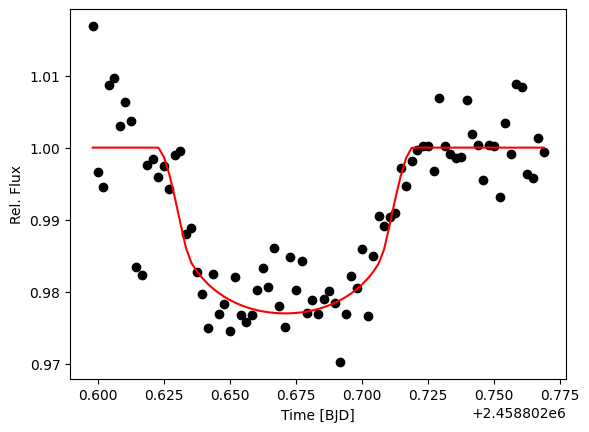

In [6]:
# let's over plot the transit model too
from exotic.api.elca import transit

time, flux, fluxerr, airmass, airmasscorr = result.observations[0].get_data()

plt.plot(time, flux/airmasscorr, 'ko')
plt.plot(time, transit(time, result.observations[0].parameters), 'r-')
plt.xlabel("Time [BJD]")
plt.ylabel("Rel. Flux")

## Fit a single lightcurve using EXOTIC

In [7]:
from exotic.api.elca import lc_fitter

# only define bounds for the "free" parameters during fitting
mybounds = {
    # [lower, upper]
    'rprs':[0,0.2],
    'tmid':[ result.ephemeris['Tc']-0.02,
             result.ephemeris['Tc']+0.02],
    'inc':[ result.observations[0].parameters['inc']-3, 
            min(90,result.observations[0].parameters['inc']+3)],
    'a2':[-0.5,0.5] # airmass curvature
}

# add limb darkening priors or generate them from a model (e.g. exotethys)
transit_priors['u0'] = result.observations[0].parameters['u0']
transit_priors['u1'] = result.observations[0].parameters['u1']
transit_priors['u2'] = result.observations[0].parameters['u2']
transit_priors['u3'] = result.observations[0].parameters['u3']

# fit the light curve
myfit = lc_fitter(time, flux, fluxerr, airmass, deepcopy(transit_priors), mybounds)

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-3e+01   [-34.8862..-34.8858]*| it/evals=6240/14899 eff=43.0375% N=400   0 0  0  
[ultranest] Likelihood function evaluations: 14978
[ultranest]   logZ = -45.92 +- 0.0809
[ultranest] Effective samples strategy satisfied (ESS = 1958.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.08, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.08 tail:0.01 total:0.08 required:<0.50
[ultranest] done iterating.


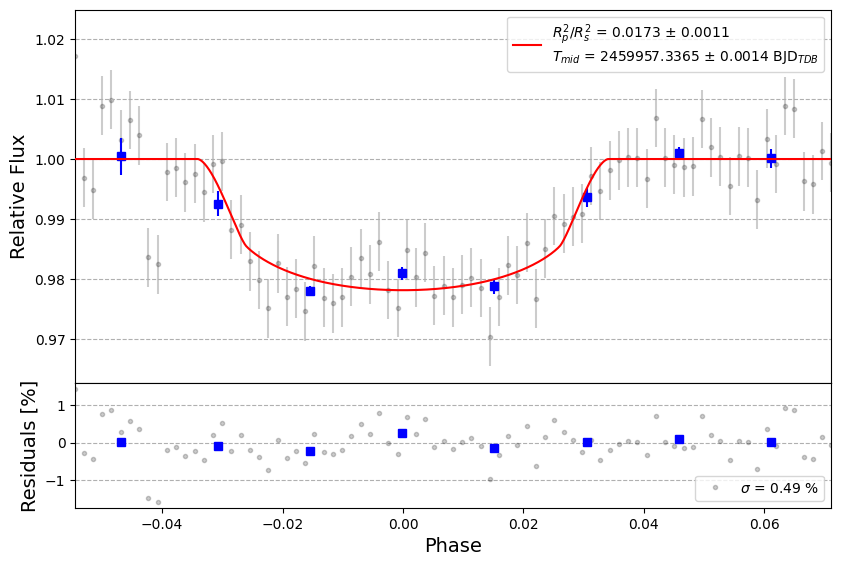

In [8]:
myfit.plot_bestfit()
plt.show()

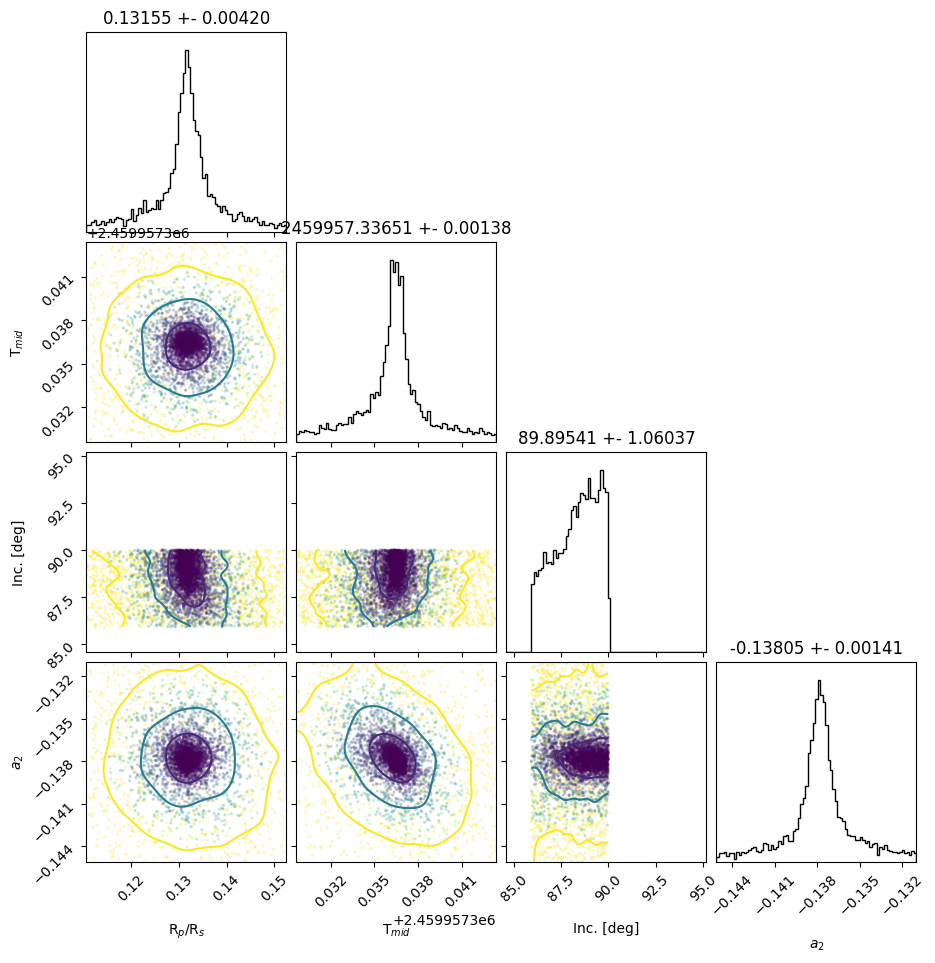

In [9]:
# show the posterior distributions
myfit.plot_triangle()
plt.show()

# Fit multiple light curves

We're going to optimize the multi-lightcurve fit by first fitting the lightcurves individually to remove airmass variations and then we'll perform a joint simultaneous fit called "global" fit, which has shared parameters like Rp/Rs, Inclination, Tmid and Period across all the light curves.

In [10]:
from astropy.time import Time
from copy import deepcopy
from exotic.api.elca import glc_fitter

# prep data for global fitter
input_data = []

# free parameters for each light curve
local_bounds = []

In [11]:
# fit the individual light curves from Exoplanet Watch and detrend airmass extinction
for n,obs in enumerate(result.observations):

    try:
        time, flux, fluxerr, airmass, airmasscorr = obs.get_data()
    except:
        data = obs.get_data()
        time, flux, fluxerr, airmass = data[:,0], data[:,1], data[:,2], data[:,3]

    # add limb darkening priors or generate them from a model (e.g. exotethys)
    transit_priors['u0'] = result.observations[n].parameters['u0']
    transit_priors['u1'] = result.observations[n].parameters['u1']
    transit_priors['u2'] = result.observations[n].parameters['u2']
    transit_priors['u3'] = result.observations[n].parameters['u3']
    prior = deepcopy(transit_priors)

    # compute tmid closest to observations
    tmid = prior['tmid']
    per = prior['per']
    obs_time = 0.5*(time.min() + time.max())
    obs_tmid = tmid + per*np.round((obs_time - tmid)/per)

    # mask out nans and 0 errors
    mask = np.isnan(flux) | (fluxerr <= 0) | np.isnan(fluxerr) | (airmass <= 1)
    
    if mask.sum() == len(flux):
        continue

    time = time[~mask]
    flux = flux[~mask]
    fluxerr = fluxerr[~mask]
    airmass = airmass[~mask]

    # only define bounds for the "free" parameters during fitting
    mybounds = {
        # [lower, upper]
        'rprs':[0, prior['rprs']*2],
        'tmid':[ obs_tmid-0.05,
                 obs_tmid+0.05],
        'inc':[ prior['inc']-3, min(90,prior['inc']+3)],
        'a2':[-0.5,0.5] # airmass curvature
    }

    try:
        # fit the light curve
        myfit = lc_fitter(time, flux, fluxerr, airmass, prior, mybounds) 
    except:
        print(f"Failed to fit {obs.obscode['id']}")
        continue

    rprs2 = myfit.parameters['rprs']**2
    rprs2err = myfit.errors['rprs']*2*myfit.parameters['rprs']

    # residuals must be smaller than transit depth
    if myfit.res_stdev > prior['rprs']**2:
        print(f"Skipping {obs.obscode['id']} due to large residuals")
        continue
    elif rprs2-3*rprs2err < 0: # 3 sigma clip
        print(f"Skipping {obs.obscode['id']} due to null transit detection")
    elif np.std(flux) > 0.03:  # ignore noisy data
        print(f"Skipping {obs.obscode['id']} due to high scatter")
        continue
    else:
        #prior = deepcopy(result.observations[n].parameters)

        # add data to list
        input_data.append({
            'time':time,
            'flux':myfit.detrended,
            'ferr':myfit.detrendederr,
            'airmass':np.zeros_like(time),
            'priors':prior,
            'name':f"{obs.obscode['id']}",

            # save individual fit parameters
            'parameters':myfit.parameters,
            'errors':myfit.errors,
            'res_std':myfit.res_stdev
        })

        # add parameter for individual airmass detrending
        local_bounds.append({}) 

        # print some timing info
        mint = Time(input_data[-1]['time'].min(),format='jd').isot
        maxt = Time(input_data[-1]['time'].max(),format='jd').isot
        maxphase = (input_data[-1]['time'].max() - prior['tmid'])/prior['per']
        minphase = (input_data[-1]['time'].min() - prior['tmid'])/prior['per']
        print(f"{input_data[-1]['name']} {len(input_data)} : {mint} ({minphase:.4f}) - {maxt} ({maxphase:.4f})")

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-3e+01   [-34.8710..-34.8707]*| it/evals=6920/17480 eff=40.5152% N=400        0  
[ultranest] Likelihood function evaluations: 17513
[ultranest]   logZ = -47.56 +- 0.1522
[ultranest] Effective samples strategy satisfied (ESS = 1936.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.
Skipping FMAA due to high scatter
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-4e+01   [-41.3758..-41.3756]*| it/evals=3640/16577 eff=22.5011% N=400 
[ultranest] Likelihood function evaluations: 16814
[ultranest]   logZ = -45.89 +- 0.05972
[ultranest] Effective samples strategy satisfied (ESS = 1462.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.06, need <0.5)
[ultranest]   logZ error budget: single: 0.09 bs:0.06 tail:0.01 total:0.06 required:<0.50
[ultranest] done iterating.
Skipping FMAA due to large residuals
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-3e+01   [-31.8273..-31.8270]*| it/evals=5920/16611 eff=36.5184% N=400       
[ultranest] Likelihood function evaluations: 16629
[ultranest]   logZ = -41.97 +- 0.1077
[ultranest] Effective samples strategy satisfied (ESS = 2057.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.01 total:0.11 required:<0.50
[ultranest] done iterating.
Skipping FMAA due to high scatter
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-4e+01   [-37.7336..-37.7335]*| it/evals=5720/20357 eff=28.6616% N=400     
[ultranest] Likelihood function evaluations: 20414
[ultranest]   logZ = -47.39 +- 0.1135
[ultranest] Effective samples strategy satisfied (ESS = 2247.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.14 bs:0.11 tail:0.01 total:0.11 required:<0.50
[ultranest] done iterating.
FMAA 1 : 2020-10-24T04:15:46.520 (-0.0601) - 2020-10-24T08:24:37.407 (0.0670)
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-4e+01   [-36.5799..-36.5789]*| it/evals=6400/19218 eff=34.0100% N=400     
[ultranest] Likelihood function evaluations: 19347
[ultranest]   logZ = -47.98 +- 0.1128
[ultranest] Effective samples strategy satisfied (ESS = 2459.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.01 total:0.11 required:<0.50
[ultranest] done iterating.
FMAA 2 : 2020-10-28T06:10:06.251 (-0.0587) - 2020-10-28T10:26:06.868 (0.0720)
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-19.2639..-19.2638]*| it/evals=5280/15971 eff=33.9092% N=400  
[ultranest] Likelihood function evaluations: 15996
[ultranest]   logZ = -27.82 +- 0.09947
[ultranest] Effective samples strategy satisfied (ESS = 2245.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.13 bs:0.10 tail:0.01 total:0.10 required:<0.50
[ultranest] done iterating.
BTSB 3 : 2021-09-18T07:29:03.908 (-0.0528) - 2021-09-18T11:53:05.427 (0.0820)
Failed to fit KADB
[ultranest] Sampling 400 live points from prior ...


/Users/kpearson/Programs/exoplanets/EXOTIC/exotic/api/elca.py:301: RuntimeWarning: divide by zero encountered in divide
  detrend = self.data / model  # used to estimate a1
/Users/kpearson/Programs/exoplanets/EXOTIC/exotic/api/elca.py:302: RuntimeWarning: invalid value encountered in multiply
  model *= np.median(detrend)


[ultranest] Explored until L=-3e+02  .68 [-291.8408..-291.8407]*| it/evals=7880/21534 eff=37.2859% N=400   0  
[ultranest] Likelihood function evaluations: 21619
[ultranest]   logZ = -306.9 +- 0.09976
[ultranest] Effective samples strategy satisfied (ESS = 2102.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.10 tail:0.01 total:0.10 required:<0.50
[ultranest] done iterating.
KADB 4 : 2021-11-06T06:36:32.314 (-0.0559) - 2021-11-06T10:32:41.654 (0.0646)
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+02  .21 [-192.3495..-192.3495]*| it/evals=7720/20761 eff=37.9156% N=400   00  
[ultranest] Likelihood function evaluations: 20762
[ultranest]   logZ = -207 +- 0.1353
[ultranest] Effective samples strategy satisfied (ESS = 2110.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.18 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.
KADB 5 : 2021-11-28T01:21:27.994 (-0.0416) - 2021-11-28T04:44:29.789 (0.0620)
Failed to fit KADB
[ultranest] Sampling 400 live points from prior ...


/Users/kpearson/Programs/exoplanets/EXOTIC/exotic/api/elca.py:301: RuntimeWarning: divide by zero encountered in divide
  detrend = self.data / model  # used to estimate a1
/Users/kpearson/Programs/exoplanets/EXOTIC/exotic/api/elca.py:301: RuntimeWarning: overflow encountered in divide
  detrend = self.data / model  # used to estimate a1
/Users/kpearson/Programs/exoplanets/EXOTIC/exotic/api/elca.py:300: RuntimeWarning: overflow encountered in exp
  model *= np.exp(self.prior['a2'] * self.airmass)


[ultranest] Explored until L=-8  01 [-8.0829..-8.0827]*| it/evals=4200/11725 eff=37.0861% N=400 0  
[ultranest] Likelihood function evaluations: 11786
[ultranest]   logZ = -14 +- 0.07175
[ultranest] Effective samples strategy satisfied (ESS = 2235.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.07, need <0.5)
[ultranest]   logZ error budget: single: 0.10 bs:0.07 tail:0.01 total:0.07 required:<0.50
[ultranest] done iterating.
Skipping GSAD due to null transit detection
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+02  .84 [-126.9715..-126.9714]*| it/evals=6160/20901 eff=30.0473% N=400  
[ultranest] Likelihood function evaluations: 21086
[ultranest]   logZ = -137.8 +- 0.1124
[ultranest] Effective samples strategy satisfied (ESS = 1920.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.01 total:0.11 required:<0.50
[ultranest] done iterating.
KADB 6 : 2021-12-17T01:39:51.322 (-0.0544) - 2021-12-17T05:41:45.398 (0.0692)
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-4e+02  .42 [-375.7441..-375.7440]*| it/evals=9560/30693 eff=31.5584% N=400 0 0  
[ultranest] Likelihood function evaluations: 30775
[ultranest]   logZ = -395 +- 0.1722
[ultranest] Effective samples strategy satisfied (ESS = 2351.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.17, need <0.5)
[ultranest]   logZ error budget: single: 0.21 bs:0.17 tail:0.01 total:0.17 required:<0.50
[ultranest] done iterating.
KADB 7 : 2022-01-05T02:33:41.386 (-0.0631) - 2022-01-05T06:45:40.781 (0.0655)
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-7e+01   [-71.8492..-71.8483]*| it/evals=6400/22487 eff=28.9763% N=400   0 0  
[ultranest] Likelihood function evaluations: 22496
[ultranest]   logZ = -83.11 +- 0.09062
[ultranest] Effective samples strategy satisfied (ESS = 2344.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.09 tail:0.01 total:0.09 required:<0.50
[ultranest] done iterating.
FMAA 8 : 2022-01-05T02:34:20.222 (-0.0538) - 2022-01-05T06:46:08.826 (0.0747)
Failed to fit KADB
[ultranest] Sampling 400 live points from prior ...


/Users/kpearson/Programs/exoplanets/EXOTIC/exotic/api/elca.py:300: RuntimeWarning: overflow encountered in exp
  model *= np.exp(self.prior['a2'] * self.airmass)
/Users/kpearson/Programs/exoplanets/EXOTIC/exotic/api/elca.py:302: RuntimeWarning: invalid value encountered in multiply
  model *= np.median(detrend)
/Users/kpearson/Programs/exoplanets/EXOTIC/exotic/api/elca.py:301: RuntimeWarning: divide by zero encountered in divide
  detrend = self.data / model  # used to estimate a1


[ultranest] Explored until L=-3e+01   [-30.7768..-30.7767]*| it/evals=3120/10031 eff=32.3954% N=400 
[ultranest] Likelihood function evaluations: 10111
[ultranest]   logZ = -33.97 +- 0.04338
[ultranest] Effective samples strategy satisfied (ESS = 1931.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.04, need <0.5)
[ultranest]   logZ error budget: single: 0.06 bs:0.04 tail:0.01 total:0.04 required:<0.50
[ultranest] done iterating.
Skipping DJEI due to large residuals
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-3e+01   [-31.8539..-31.8534]*| it/evals=4360/13179 eff=34.1185% N=400  0 
[ultranest] Likelihood function evaluations: 13312
[ultranest]   logZ = -38.11 +- 0.08043
[ultranest] Effective samples strategy satisfied (ESS = 1878.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.08, need <0.5)
[ultranest]   logZ error budget: single: 0.11 bs:0.08 tail:0.01 total:0.08 required:<0.50
[ultranest] done iterating.
Skipping OAS due to large residuals
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-1e+02  .79 [-116.9384..-116.9383]*| it/evals=6040/21396 eff=28.7674% N=400 
[ultranest] Likelihood function evaluations: 21455
[ultranest]   logZ = -127.5 +- 0.1049
[ultranest] Effective samples strategy satisfied (ESS = 2250.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.10 tail:0.01 total:0.11 required:<0.50
[ultranest] done iterating.
Skipping DLMA due to large residuals
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+02  .61 [-164.7802..-164.7801]*| it/evals=6300/20051 eff=32.0594% N=400  
[ultranest] Likelihood function evaluations: 20151
[ultranest]   logZ = -175.9 +- 0.1088
[ultranest] Effective samples strategy satisfied (ESS = 1929.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.01 total:0.11 required:<0.50
[ultranest] done iterating.
PJAE 9 : 2022-11-26T03:31:56.152 (-0.0670) - 2022-11-26T07:58:33.875 (0.0691)
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-5e+02  .42 [-539.7560..-539.7559]*| it/evals=9200/35563 eff=26.1639% N=400    0  0 
[ultranest] Likelihood function evaluations: 35720
[ultranest]   logZ = -558.1 +- 0.1939
[ultranest] Effective samples strategy satisfied (ESS = 2065.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.19, need <0.5)
[ultranest]   logZ error budget: single: 0.20 bs:0.19 tail:0.01 total:0.19 required:<0.50
[ultranest] done iterating.
SAJB 10 : 2023-01-12T18:05:56.918 (-0.0615) - 2023-01-12T22:05:59.021 (0.0611)


## Run the next block of code only if you want to add TESS data to the global fit


In order to make lightcurves from TESS please inspect the file `tess.py` in the `examples/` directory. You will need to set up a new environment and then run the script based on instructions at the top of the file. Once you have the lightcurves, you can run the next block of code to add them to the global fit.

In [12]:
import glob
from pylightcurve import exotethys

# generate limb darkening coefficients for TESS
get_prior = lambda key: float(result.priors[key]['value'])
u0,u1,u2,u3 = exotethys(get_prior('LOGG'), get_prior('T*'), get_prior('FE/H'), 'TESS', method='claret', stellar_model='phoenix')

# get files from local directory
tess_lightcurves = glob.glob(f"output/{target.replace(' ','_').replace('-','_')}/*_AAVSO.txt")
print(f"Found {len(tess_lightcurves)} TESS light curves")

# add TESS data
for n,lc in enumerate(tess_lightcurves):

    # read in data
    time, flux, fluxerr, airmass, airmasscorr = np.loadtxt(lc, unpack=True, delimiter=',')
    prior = deepcopy(transit_priors)
    prior['u0'] = u0
    prior['u1'] = u1
    prior['u2'] = u2
    prior['u3'] = u3
    prior['tmid'] = result.ephemeris['Tc']
    prior['per'] = result.ephemeris['Period']
    prior['a2'] = 0.0 # no airmass correction for TESS

    # compute tmid closest to observations
    tmid = prior['tmid']
    per = prior['per']
    obs_time = 0.5*(time.min() + time.max())
    obs_tmid = tmid + per*np.round((obs_time - tmid)/per)

    # only define bounds for the "free" parameters during fitting
    mybounds = {
        # [lower, upper]
        'rprs':[0, prior['rprs']*2],
        'tmid':[ obs_tmid-0.05,
                 obs_tmid+0.05],
        'inc':[ prior['inc']-5, min(90,prior['inc']+5)]
    }

    try:
        myfit = lc_fitter(time, flux, fluxerr, airmass, prior, mybounds) 
    except:
        print(f"Failed to fit {obs.obscode['id']}")
        continue
    
    # add data to list
    input_data.append({
        'time':time,
        'flux':flux,
        'ferr':fluxerr,
        'airmass':np.zeros(time.shape),
        'priors':prior,
        'name':f"TESS",

        # save individual fit parameters
        'parameters':myfit.parameters,
        'errors':myfit.errors,
        'res_std':myfit.res_stdev
    })

    # no airmass detrending
    local_bounds.append({})

    # print some timing info
    mint = Time(input_data[-1]['time'].min(),format='jd').isot
    maxt = Time(input_data[-1]['time'].max(),format='jd').isot
    maxphase = (input_data[-1]['time'].max() - prior['tmid'])/prior['per']
    minphase = (input_data[-1]['time'].min() - prior['tmid'])/prior['per']
    print(f"{input_data[-1]['name']} {len(input_data)} : {mint} ({minphase:.4f}) - {maxt} ({maxphase:.4f})")

Found 19 TESS light curves
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-3e+01   [-31.5109..-31.5109]*| it/evals=6040/12097 eff=51.6372% N=400   0   
[ultranest] Likelihood function evaluations: 12125
[ultranest]   logZ = -42.03 +- 0.1262
[ultranest] Effective samples strategy satisfied (ESS = 1723.1, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.13 tail:0.01 total:0.13 required:<0.50
[ultranest] done iterating.
TESS 11 : 2018-10-20T16:25:32.462 (-0.1179) - 2018-10-21T00:07:32.695 (0.1180)
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-3e+01   [-25.3255..-25.3253]*| it/evals=6040/11613 eff=53.8660% N=400    0 0 
[ultranest] Likelihood function evaluations: 11618
[ultranest]   logZ = -35.78 +- 0.111
[ultranest] Effective samples strategy satisfied (ESS = 1710.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.01 total:0.11 required:<0.50
[ultranest] done iterating.
TESS 12 : 2018-11-03T06:51:27.594 (-0.1172) - 2018-11-03T14:31:27.225 (0.1177)
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-7e+02  .50 [-652.6683..-652.6682]*| it/evals=7264/15683 eff=47.5299% N=400   0   
[ultranest] Likelihood function evaluations: 15701
[ultranest]   logZ = -666.2 +- 0.152
[ultranest] Effective samples strategy satisfied (ESS = 1908.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.
TESS 13 : 2020-10-25T11:02:14.184 (-0.1180) - 2020-10-25T18:44:14.121 (0.1179)
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-22.6958..-22.6957]*| it/evals=6160/11217 eff=56.9474% N=400        
[ultranest] Likelihood function evaluations: 11226
[ultranest]   logZ = -33.5 +- 0.1361
[ultranest] Effective samples strategy satisfied (ESS = 1866.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.
TESS 14 : 2018-11-06T00:07:23.679 (-0.1174) - 2018-11-06T07:47:23.118 (0.1175)
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-24.9287..-24.9287]*| it/evals=6080/11601 eff=54.2809% N=400   0   
[ultranest] Likelihood function evaluations: 11623
[ultranest]   logZ = -35.54 +- 0.1007
[ultranest] Effective samples strategy satisfied (ESS = 1808.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.10 tail:0.01 total:0.10 required:<0.50
[ultranest] done iterating.
TESS 15 : 2018-11-11T10:41:11.726 (-0.1176) - 2018-11-11T18:21:10.880 (0.1173)
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-7e+02  .08 [-671.2991..-671.2988]*| it/evals=7320/17437 eff=42.9653% N=400   0   
[ultranest] Likelihood function evaluations: 17474
[ultranest]   logZ = -684.9 +- 0.1265
[ultranest] Effective samples strategy satisfied (ESS = 1990.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.13 tail:0.01 total:0.13 required:<0.50
[ultranest] done iterating.
TESS 16 : 2020-10-26T19:40:33.776 (-0.1180) - 2020-10-27T03:22:33.629 (0.1179)
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-3e+01   [-25.5443..-25.5442]*| it/evals=6240/11709 eff=55.1773% N=400      0 
[ultranest] Likelihood function evaluations: 11752
[ultranest]   logZ = -36.62 +- 0.1123
[ultranest] Effective samples strategy satisfied (ESS = 2004.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.01 total:0.11 required:<0.50
[ultranest] done iterating.
TESS 17 : 2018-11-08T17:25:18.311 (-0.1169) - 2018-11-09T01:05:17.598 (0.1180)
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-7e+02  .76 [-659.8441..-659.8441]*| it/evals=7120/13509 eff=54.3138% N=400   0   
[ultranest] Likelihood function evaluations: 13586
[ultranest]   logZ = -673.1 +- 0.1359
[ultranest] Effective samples strategy satisfied (ESS = 1915.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.
TESS 18 : 2020-10-24T02:23:54.206 (-0.1179) - 2020-10-24T10:05:54.239 (0.1180)
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-24.6140..-24.6139]*| it/evals=6120/11711 eff=54.1066% N=400    0 0 
[ultranest] Likelihood function evaluations: 11774
[ultranest]   logZ = -35.38 +- 0.1069
[ultranest] Effective samples strategy satisfied (ESS = 1890.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.09 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.01 total:0.11 required:<0.50
[ultranest] done iterating.
TESS 19 : 2018-11-12T19:19:08.037 (-0.1179) - 2018-11-13T03:01:07.137 (0.1180)
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-3e+01   [-26.2099..-26.2098]*| it/evals=6080/11724 eff=53.6913% N=400       
[ultranest] Likelihood function evaluations: 11780
[ultranest]   logZ = -36.82 +- 0.141
[ultranest] Effective samples strategy satisfied (ESS = 1750.4, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.14, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.14 tail:0.01 total:0.14 required:<0.50
[ultranest] done iterating.
TESS 20 : 2018-11-04T15:29:25.843 (-0.1174) - 2018-11-04T23:09:25.369 (0.1175)
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-20.7671..-20.7669]*| it/evals=6160/11443 eff=55.7819% N=400       
[ultranest] Likelihood function evaluations: 11494
[ultranest]   logZ = -31.59 +- 0.114
[ultranest] Effective samples strategy satisfied (ESS = 1958.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.11, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.11 tail:0.01 total:0.11 required:<0.50
[ultranest] done iterating.
TESS 21 : 2018-10-22T01:05:33.268 (-0.1173) - 2018-10-22T08:45:33.394 (0.1176)
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-3e+01   [-27.0351..-27.0351]*| it/evals=6210/11704 eff=54.9363% N=400       
[ultranest] Likelihood function evaluations: 11761
[ultranest]   logZ = -37.96 +- 0.1031
[ultranest] Effective samples strategy satisfied (ESS = 1985.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.10 tail:0.01 total:0.10 required:<0.50
[ultranest] done iterating.
TESS 22 : 2018-10-23T09:43:33.660 (-0.1173) - 2018-10-23T17:23:33.700 (0.1176)
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-3e+01   [-25.9712..-25.9708]*| it/evals=6040/11614 eff=53.8612% N=400       
[ultranest] Likelihood function evaluations: 11671
[ultranest]   logZ = -36.44 +- 0.1038
[ultranest] Effective samples strategy satisfied (ESS = 1944.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.10 tail:0.01 total:0.10 required:<0.50
[ultranest] done iterating.
TESS 23 : 2018-11-10T02:03:15.162 (-0.1175) - 2018-11-10T09:43:14.379 (0.1174)
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-7e+02  .10 [-680.1586..-680.1585]*| it/evals=7240/13135 eff=56.8512% N=400   0   
[ultranest] Likelihood function evaluations: 13193
[ultranest]   logZ = -693.7 +- 0.1316
[ultranest] Effective samples strategy satisfied (ESS = 1920.5, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.06 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.13, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.13 tail:0.01 total:0.13 required:<0.50
[ultranest] done iterating.
TESS 24 : 2020-10-28T04:19:13.024 (-0.1177) - 2020-10-28T12:01:12.799 (0.1182)
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-7e+02  .08 [-675.2161..-675.2161]*| it/evals=7231/14131 eff=52.6619% N=400   0    
[ultranest] Likelihood function evaluations: 14144
[ultranest]   logZ = -688.7 +- 0.12
[ultranest] Effective samples strategy satisfied (ESS = 1936.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.12 tail:0.01 total:0.12 required:<0.50
[ultranest] done iterating.
TESS 25 : 2020-10-22T17:45:13.750 (-0.1179) - 2020-10-23T01:27:13.910 (0.1180)
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-23.7460..-23.7459]*| it/evals=6120/11437 eff=55.4499% N=400    0  
[ultranest] Likelihood function evaluations: 11476
[ultranest]   logZ = -34.52 +- 0.1021
[ultranest] Effective samples strategy satisfied (ESS = 1919.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.10 tail:0.01 total:0.10 required:<0.50
[ultranest] done iterating.
TESS 26 : 2018-10-26T02:59:33.409 (-0.1178) - 2018-10-26T10:39:33.296 (0.1171)
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-7e+02  .46 [-747.7095..-747.7094]*| it/evals=6960/15404 eff=46.3876% N=400   0   
[ultranest] Likelihood function evaluations: 15483
[ultranest]   logZ = -760.4 +- 0.1172
[ultranest] Effective samples strategy satisfied (ESS = 1922.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.12, need <0.5)
[ultranest]   logZ error budget: single: 0.17 bs:0.12 tail:0.01 total:0.12 required:<0.50
[ultranest] done iterating.
TESS 27 : 2020-10-29T12:57:51.950 (-0.1179) - 2020-10-29T20:39:31.653 (0.1178)
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-3e+01   [-27.0526..-27.0525]*| it/evals=6160/12482 eff=50.9849% N=400   0   
[ultranest] Likelihood function evaluations: 12482
[ultranest]   logZ = -37.8 +- 0.1033
[ultranest] Effective samples strategy satisfied (ESS = 1910.7, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.10, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.10 tail:0.01 total:0.10 required:<0.50
[ultranest] done iterating.
TESS 28 : 2018-11-07T08:45:21.159 (-0.1178) - 2018-11-07T16:27:20.516 (0.1181)
[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-2e+01   [-21.5162..-21.5160]*| it/evals=6240/11583 eff=55.7990% N=400       
[ultranest] Likelihood function evaluations: 11590
[ultranest]   logZ = -32.45 +- 0.1479
[ultranest] Effective samples strategy satisfied (ESS = 1897.2, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.47+-0.08 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.15, need <0.5)
[ultranest]   logZ error budget: single: 0.15 bs:0.15 tail:0.01 total:0.15 required:<0.50
[ultranest] done iterating.
TESS 29 : 2018-10-24T18:21:33.697 (-0.1176) - 2018-10-25T02:01:33.657 (0.1173)


In [13]:
prior

{'ecc': 0.0074,
 'inc': 87.713010716479,
 'omega': -166.0,
 'tmid': 2458416.424893059,
 'a1': 1,
 'a2': 0.0,
 'ars': 5.332,
 'rprs': 0.11810311272220649,
 'per': 1.3600290306112939,
 'u0': 0.5007438874039994,
 'u1': -0.08351946282301767,
 'u2': 0.4675323137274613,
 'u3': -0.2166556367766898}

In [14]:
input_data[0]['priors']

{'ecc': 0.0074,
 'inc': 86.07999373157074,
 'omega': -166.0,
 'tmid': 2459146.759302781,
 'a1': 1,
 'a2': -0.0027830397249283267,
 'ars': 5.332,
 'rprs': 0.1343620266815629,
 'per': 1.36002869,
 'u0': 1.9620417119554874,
 'u1': -3.53068378927721,
 'u2': 4.032966684059403,
 'u3': -1.4643245466417936}

In [15]:
# bounds shared by all light curves
global_bounds = {
    'rprs':(prior['rprs']*0.75, prior['rprs']*1.33),
    'inc':(prior['inc']-5, min(90,prior['inc']+5)),
    'per':( result.ephemeris['Period']-0.001,
            result.ephemeris['Period']+0.001),
    'tmid':( result.ephemeris['Tc']-0.01,
             result.ephemeris['Tc']+0.01),
}

global_fit = glc_fitter(input_data, global_bounds, local_bounds, individual_fit=False, verbose=True)

[ultranest] Sampling 400 live points from prior ...


[ultranest] Explored until L=-7e+03  740.55 [-6740.6776..-6740.6775]*| it/evals=10798/27291 eff=40.1547% N=400    
[ultranest] Likelihood function evaluations: 27293
[ultranest]   logZ = -6763 +- 0.1661
[ultranest] Effective samples strategy satisfied (ESS = 2108.8, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.17, need <0.5)
[ultranest]   logZ error budget: single: 0.23 bs:0.17 tail:0.01 total:0.17 required:<0.50
[ultranest] done iterating.


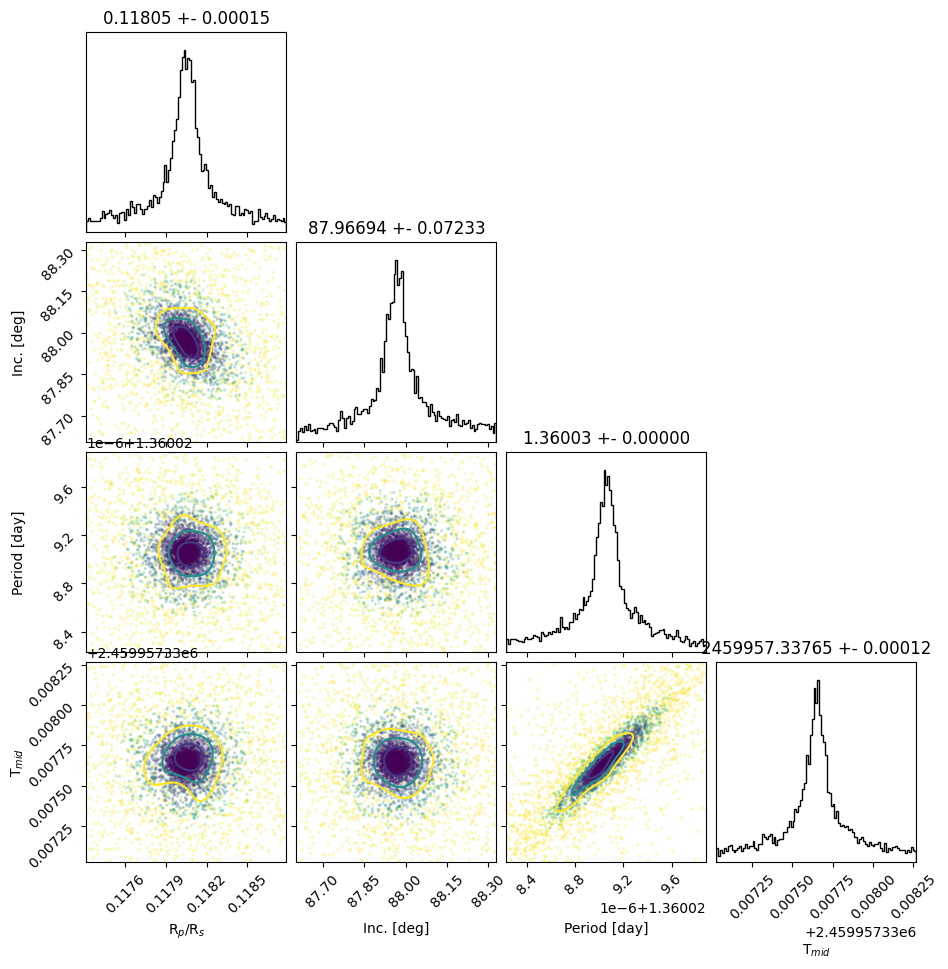

In [16]:
global_fit.plot_triangle()
plt.savefig(os.path.join(output_dir,"posteriors.png"),facecolor='white')

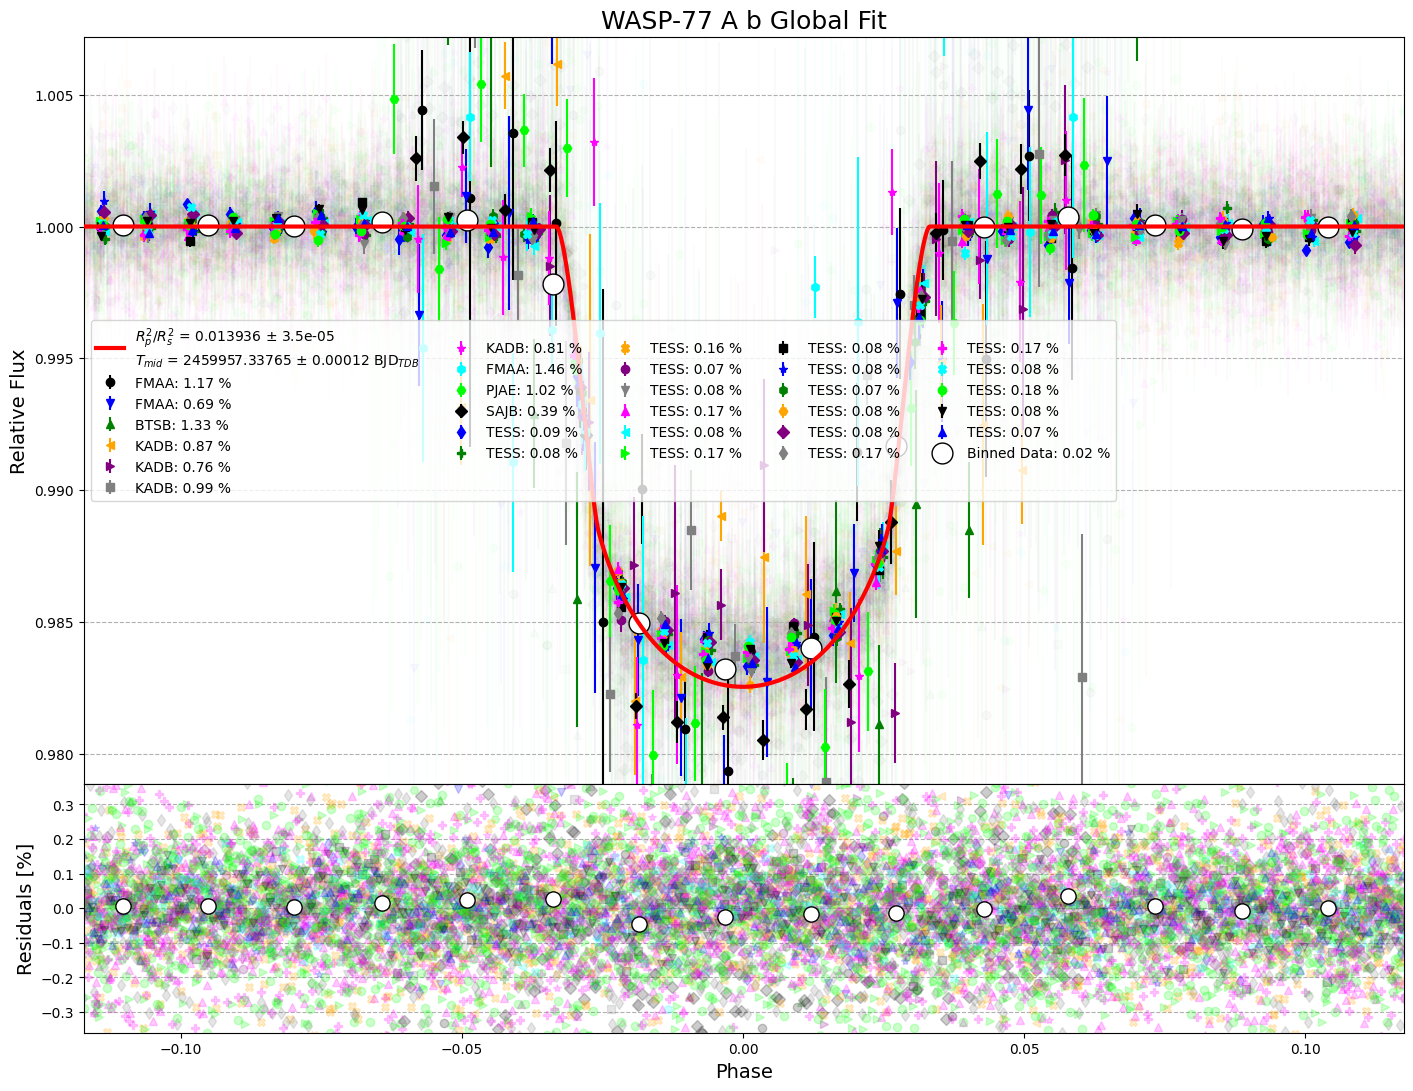

In [17]:
global_fit.plot_bestfit(alpha=0.025, bin_dt = 15./60/24, title=f"{target} Global Fit",phase_limits='median', ylim_sigma=10)
plt.savefig(os.path.join(output_dir,"bestfit.png"),facecolor='white')

In [18]:
prior

{'ecc': 0.0074,
 'inc': 87.713010716479,
 'omega': -166.0,
 'tmid': 2458416.424893059,
 'a1': 1,
 'a2': 0.0,
 'ars': 5.332,
 'rprs': 0.11810311272220649,
 'per': 1.3600290306112939,
 'u0': 0.5007438874039994,
 'u1': -0.08351946282301767,
 'u2': 0.4675323137274613,
 'u3': -0.2166556367766898}

In [19]:
global_fit.parameters

{'ecc': 0.0074,
 'inc': 87.96694041934134,
 'omega': -166.0,
 'tmid': 2459957.337648647,
 'a1': 1,
 'a2': -0.0027830397249283267,
 'ars': 5.332,
 'rprs': 0.11805133900539692,
 'per': 1.360029059910445,
 'u0': 1.9620417119554874,
 'u1': -3.53068378927721,
 'u2': 4.032966684059403,
 'u3': -1.4643245466417936}

In [20]:
global_fit.lc_data[0]['parameters']

{'ecc': 0.0074,
 'inc': 86.056714996829,
 'omega': -166.0,
 'tmid': 2459146.7588232975,
 'a1': 0.9417598570625737,
 'a2': -0.005521919257919672,
 'ars': 5.332,
 'rprs': 0.13602179453975768,
 'per': 1.36002869,
 'u0': 1.9620417119554874,
 'u1': -3.53068378927721,
 'u2': 4.032966684059403,
 'u3': -1.4643245466417936}

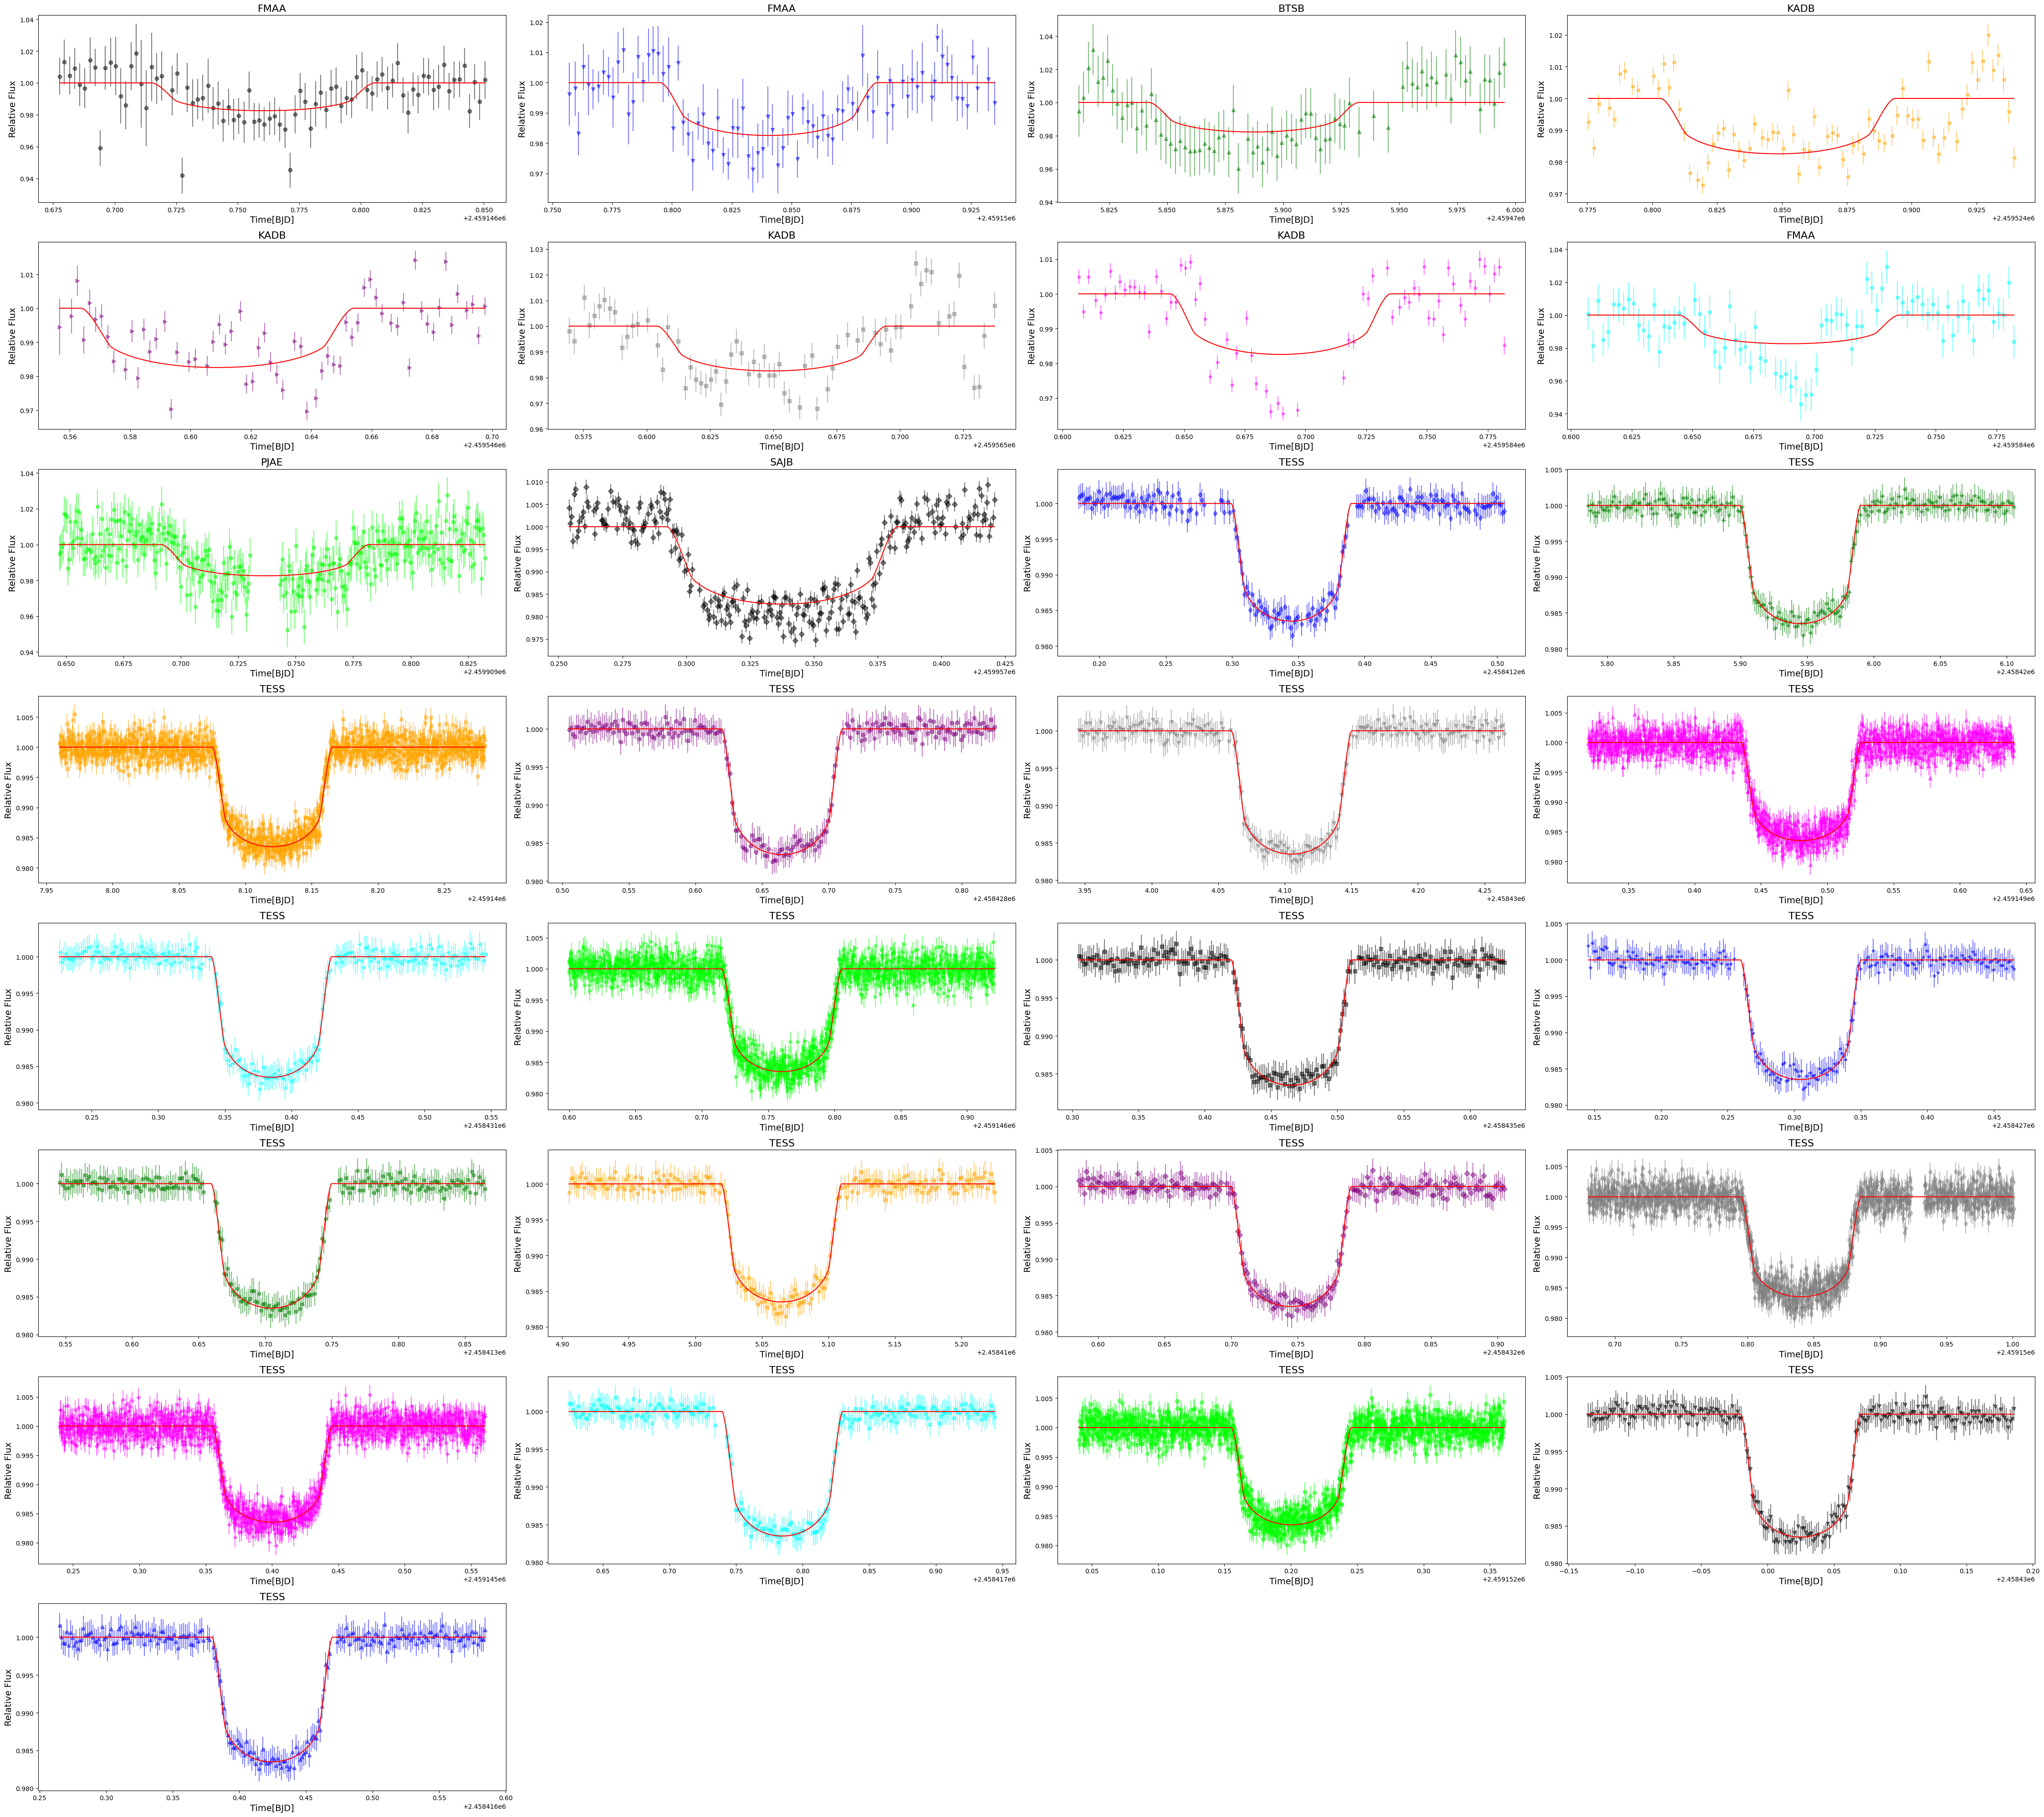

In [21]:
global_fit.plot_bestfits()
plt.savefig(os.path.join(output_dir,"bestfits.png"),facecolor='white')

## LaTeX Output for Global Fit

In [22]:
# create latex formatted table for global fit parameters
for key in global_fit.errors:
    print(f"{key} & {global_fit.parameters[key]:.5f} $\pm$ {global_fit.errors[key]:.7f} \\\\")

rprs & 0.11805 $\pm$ 0.0001471 \\
inc & 87.96694 $\pm$ 0.0723284 \\
per & 1.36003 $\pm$ 0.0000002 \\
tmid & 2459957.33765 $\pm$ 0.0001239 \\


In [23]:
# create column headers
header = "Name"
for key in input_data[0]['errors']:
    # skip airmass parameters
    if 'a1' in key or 'a2' in key:
        continue
    header += f" & {key}"
header += " & $\sigma_{res}$"
header += " \\\\"
print(header)

# create latex formatted string
for lcdata in input_data:
    fstring = lcdata['name']
    for key in lcdata['errors']:

        # skip airmass parameters
        if 'a1' in key or 'a2' in key:
            continue

        # add to string
        fstring += f" & {lcdata['parameters'][key]:.6f} $\pm$ {lcdata['errors'][key]:.6f}"

    # add res_std
    fstring += f" & {lcdata['res_std']:.6f}"
    fstring += f" \\\\"
    print(fstring)

Name & rprs & tmid & inc & $\sigma_{res}$ \\
FMAA & 0.136022 $\pm$ 0.010948 & 2459146.758823 $\pm$ 0.004392 & 86.056715 $\pm$ 1.190071 & 0.011515 \\
FMAA & 0.125723 $\pm$ 0.007814 & 2459150.837679 $\pm$ 0.002041 & 85.917627 $\pm$ 1.021602 & 0.006658 \\
BTSB & 0.167016 $\pm$ 0.009833 & 2459475.883579 $\pm$ 0.004874 & 89.584823 $\pm$ 1.002267 & 0.010720 \\
KADB & 0.109107 $\pm$ 0.002481 & 2459524.851389 $\pm$ 0.000602 & 89.985425 $\pm$ 0.475624 & 0.008494 \\
KADB & 0.109676 $\pm$ 0.003097 & 2459546.613226 $\pm$ 0.000790 & 89.941082 $\pm$ 0.603683 & 0.007162 \\
KADB & 0.132647 $\pm$ 0.004659 & 2459565.643569 $\pm$ 0.001527 & 87.243102 $\pm$ 1.170833 & 0.009445 \\
KADB & 0.140129 $\pm$ 0.001670 & 2459584.692330 $\pm$ 0.000474 & 85.910036 $\pm$ 0.025738 & 0.007218 \\
FMAA & 0.149629 $\pm$ 0.009138 & 2459584.680663 $\pm$ 0.002911 & 85.911414 $\pm$ 1.139028 & 0.013322 \\
PJAE & 0.139842 $\pm$ 0.005205 & 2459909.738916 $\pm$ 0.001110 & 87.102550 $\pm$ 1.092492 & 0.009798 \\
SAJB & 0.132836 $\p

In [24]:
dude()

NameError: name 'dude' is not defined

## Mid-transit times and uncertainties from Nasa Exoplanet Archive

In [ ]:
nea_tmids = []
nea_tmids_err = []

for i in range(len(result.ephemeris['nea_tmids'])):
    clean_ref = result.ephemeris['nea_references'][i].replace('%20', ' ').replace('&amp;', '&')

    # remove ExoFOP-TESS values since we're using TESS data itself, no need to double count
    if 'ExoFOP-TESS' in clean_ref:
        continue

    nea_tmids.append(result.ephemeris['nea_tmids'][i])
    nea_tmids_err.append(result.ephemeris['nea_tmids_err'][i])

    print(f"{float(result.ephemeris['nea_tmids'][i]):.6f} +- {float(result.ephemeris['nea_tmids_err'][i]):.6f} : {clean_ref}")

## Fit an ephemeris to the mid-transit times

T_next = T_0 + n * Period

In [ ]:
from exotic.api.nested_linear_fitter import linear_fitter

# min and max values to search between for fitting the ephemeris
bounds = {
    'm':[ # orbital period
        global_fit.parameters['per']-10*global_fit.errors['per'], 
        global_fit.parameters['per']+10*global_fit.errors['per']
    ], 
    'b':[ # mid-transit time
        global_fit.parameters['tmid']-10*global_fit.errors['tmid'],
        global_fit.parameters['tmid']+10*global_fit.errors['tmid']
    ] 
}

# used to plot red overlay in O-C figure
prior = {
    'm':[global_fit.parameters['per'], global_fit.errors['per']],   # value from global
    'b':[global_fit.parameters['tmid'], global_fit.errors['tmid']]  # value from WLS
}

# extract data from individual light curves in global fit
tmids = [lcfit['parameters']['tmid'] for lcfit in input_data]
tmids_err = [lcfit['errors']['tmid'] for lcfit in input_data]
rprs2 = [lcfit['parameters']['rprs']**2 for lcfit in input_data]
rprs = [lcfit['parameters']['rprs'] for lcfit in input_data]
rprs_err = [lcfit['errors']['rprs'] for lcfit in input_data]
res_stdev = [lcfit['res_std'] for lcfit in input_data]
name = [lcfit['name'] for lcfit in input_data]
tmids_err = np.array(tmids_err)

# filter bad data
mask = (res_stdev < np.mean(rprs2)) & (np.mean(rprs) > 5 * np.mean(rprs_err)) & (tmids_err*24*60<5)
# TODO 3sigma clip away from global ephemeris

# apply mask
tmids = np.array(tmids)[mask]
tmids_err = np.array(tmids_err)[mask]

# combine the good data from reprocessing of Exoplanet Watch and NASA Exoplanet Archive
tmids = np.array(list(tmids) + nea_tmids, dtype=float)
tmids_err = np.array(list(tmids_err) + nea_tmids_err, dtype=float)

# fit the data and compare ephemeris to global light curve fit
lf = linear_fitter( tmids, tmids_err, bounds, prior=prior )

# plot the O-C diagram
fig,ax = lf.plot_oc(prior_name='Global Fit')
plt.tight_layout()
plt.savefig(os.path.join(output_dir,"oc_global.png"),facecolor='white')
plt.close()
Image(os.path.join(output_dir,"oc_global.png"))

## Search for periodic signals in the O-C data

In [ ]:
fig,ax = lf.plot_periodogram()
plt.tight_layout()
plt.savefig(os.path.join(output_dir,"periodogram.png"),facecolor='white')
plt.close()
Image(os.path.join(output_dir,"periodogram.png"))